# Neoclassical Growth Model

This script generates the figure for the neoclassical growth model. 

In [26]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using CairoMakie
using ProgressMeter
using LaTeXStrings

  Activating project at `~/Github/micro_risks`


## Basic Code

In [15]:
# Helper functions 
f(k, m) = k^m.α

fk(k, m) = m.α * k^(m.α - 1)

fk_inverse(x, m) = (x / m.α)^(1 / (m.α - 1))

u(c, m) = (m.σ != 1) ? (c^(1 - m.σ) - 1) / (1 - m.σ) : log(c)

u_c(c, m) = (m.σ != 1) ? c^(- m.σ) : 1/c

find_kss(m) = ((1/m.β - 1 + m.δ) / m.α) ^ (1 / (m.α - 1))

find_kgolden(m) = (m.δ / m.α) ^ (1 / (m.α - 1))


# Creates the basic model struct(tupple)
function base_model(m; n = 10_000, max_μ = 20.0) 
    kss = find_kss(m)
    kgolden = find_kgolden(m)
    
    (; δ, β) = m 

    rₒ = 1/β - 1
    kmin = fk_inverse(max_μ * (rₒ + δ), m)

    return ( 
        m...,
        max_μ = max_μ, 
        kss = kss, 
        kgolden = kgolden, 
        kgrid = collect(range(kmin, kgolden, length = n)),
        n = n
    )
end


# This function obtains the corresponding neoclassical growth model policy
# The return vector contains the index of the optimal policy
function neoclassical_policy(m; atol = 1e-10, maxiters = 10_000, verbose = true)
    (; kgrid, β, δ) = m
    v0 = zero(kgrid)
    v1 = zero(kgrid)
    pol = [1 for _ in kgrid]
    for iter in 1:maxiters
        polmax = 1
        dist = zero(m.β)
        for i in eachindex(kgrid)
            k = kgrid[i]
            vmax = -Inf
            for j in polmax:length(kgrid)
                kprime = kgrid[j]
                c = f(k, m) + (1 - δ) * k - kprime
                if c > 0
                    v = u(c, m) + β * v0[j]
                    if v > vmax 
                        vmax = v
                        polmax = j
                    elseif vmax > -Inf
                        break
                    end
                end
            end
            v1[i] = vmax 
            pol[i] = polmax
            dist = max(dist, abs(vmax - v0[i]))
        end 
        verbose && mod(iter, 50) == 1 && println("$iter -- $dist")
        (dist < atol) && break 
        v1, v0 = v0, v1
    end 
    return pol
end


# This function constructs the next pair of (k_i, T_i)
# where i₁ represents the index for k_{i-1} and T₂ represents the associated 
# transfer. 
# 
# It returns the index for k_{i} and the value of T_i
function next_ki_b(i₁, m, pol, k₀, R₀)
    
    (; kgrid, β, δ) = m
        
    k₁ = kgrid[i₁]
    
    i₂ = pol[i₁]
    k₂ = kgrid[i₂]
    f₂ = f(k₂, m)

    # getting the interest rate from the consumer euler equation
    f₁ = f(k₁, m)
    k₃ = kgrid[pol[i₂]]
    c₁ = f₁ + (1 - δ) * k₁ - k₂
    c₂ = f₂ + (1 - δ) * k₂ - k₃    
    cR₂ = u_c(c₁, m) / u_c(c₂, m) / β

    # alternatively, getting the interest rate from the mpk
    R₂ = fk(k₂, m) + 1 - δ
    
    T₂ = (f₂ + (1 - δ) * k₂) - (f(k₀, m) + (1 - δ) * k₀) + R₀ * k₀ - R₂ * k₂
    
    return (i₂, T₂, R₂, cR₂) 
end


# Gets the efficient path of k, T, R up to the stationary point.
function get_path(m; pol, μ)
    (; β, δ, kgrid) = m
    
    R₀ = 1 / β  # initial interest rate
    
    # finding the index of k0 given the markup value
    k0index = findfirst(x -> x <= 0, [fk(k, m) - μ * (R₀ - 1 + δ) for k in kgrid])
    k₀ = kgrid[k0index]
    
    lst = [(k0index, 0.0, R₀, R₀)] # starting point
    
    while true 
        s0 = lst[end]
        s1 = next_ki_b(s0[1], m, pol, k₀, R₀)
        push!(lst, s1)
        if s1[1] == s0[1]
            # reached stationary point
            break
        end 
    end
    
    return lst 
end


# Computes the present value of transfers in a path. 
# idx_R indexes the interest rate to use: either from euler or from MPK (and should not matter)
function present_value_T(path; idx_R = 3)
    discount = 1.0
    sum = 0.0
    for i in 2:length(path)
        Ti = path[i][2] 
        Ri = path[i][idx_R]
        discount = discount / Ri  
        sum = sum + discount * Ti
    end 
    Rss = path[end][idx_R]
    Tss = path[end][2]
    discount = discount / Rss
    sum = sum + discount * Rss * Tss / (Rss - 1) 
end 


# Given a range of σ and μ, computes the present value of T in the 
# associated grid. 
function get_pv_T_grid(
    par; 
    range_inverse_σ = range(0.05, 10.0, length = 100), 
    range_μ = range(1.001, 5.0, length = 50), 
    idx_R = 3
)
    Tlst = zeros(length(range_inverse_σ), length(range_μ))
    p = Progress(length(range_inverse_σ))
    Threads.@threads for i in 1:length(range_inverse_σ)
        σ = 1/range_inverse_σ[i]
        m = base_model((par..., σ = σ); max_μ = range_μ[end])
        pol = neoclassical_policy(m; verbose = false)
        for (j, μ) in enumerate(range_μ)
            path = get_path(m; pol, μ);
            Tlst[i, j] = present_value_T(path; idx_R) 
        end 
        next!(p)
    end 
    return par, range_inverse_σ, range_μ, Tlst
end 

get_pv_T_grid (generic function with 1 method)

## An example

In [6]:
par = (
    α = 0.33,
    β = 0.95,
    δ = 0.1, 
    σ = 5.0
)

m = base_model(par; n = 20_000);

In [7]:
@time neo = neoclassical_policy(m);  # fast enough for our purposes

1 -- 20.65749684665574
51 -- 0.004538978866386767
101 -- 0.0002982528423145503
151 -- 2.2759459388232983e-5
201 -- 1.7505538956186228e-6
251 -- 1.346963287573999e-7
301 -- 1.0364208158364363e-8
351 -- 7.974763072127189e-10
  4.805409 seconds (175.07 k allocations: 10.213 MiB, 2.27% compilation time)


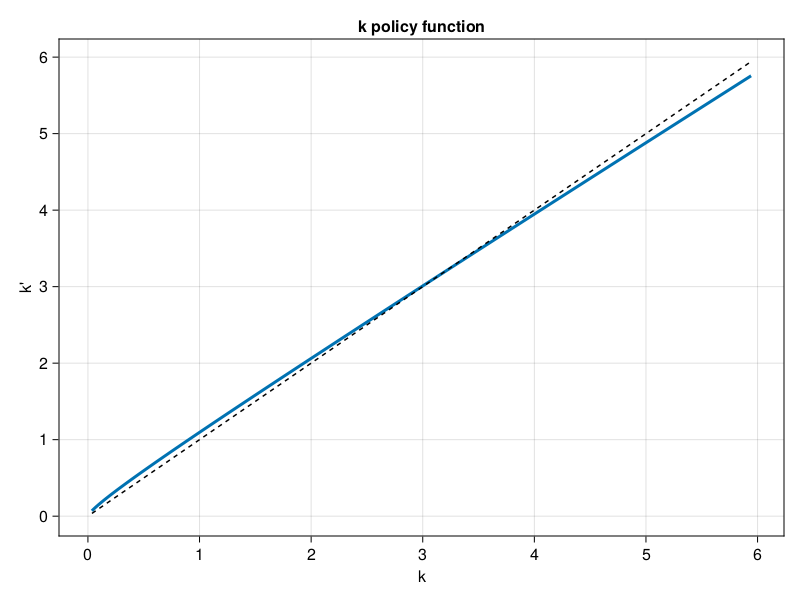

In [8]:
# Double checking that the policy looks right:

let 
    fig = Figure()
    ax = Axis(fig[1, 1], title = "k policy function", xlabel = "k", ylabel = "k'")
    lines!(ax, m.kgrid, m.kgrid[neo], linewidth = 3)
    lines!(ax, m.kgrid[[1, m.n]], m.kgrid[[1, m.n]], 
        linestyle = :dash, 
        color = :black, 
        title = "neoclassical policy")
    fig
end 

In [9]:
path = get_path(m; pol = neo, μ = 10.0);
present_value_T(path)

0.02640527983200573

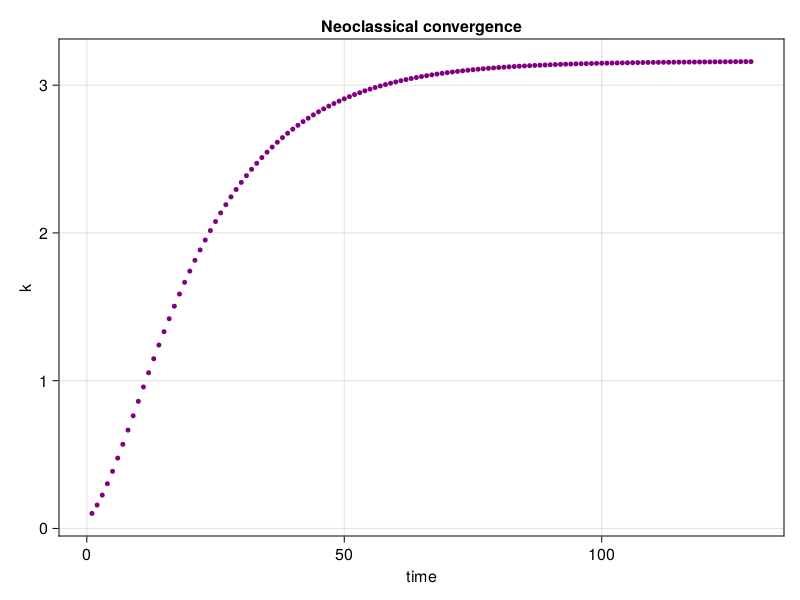

In [10]:
let
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel = "time", ylabel = "k", title = "Neoclassical convergence")
    klst = [m.kgrid[i] for (i, __) in path]
    t = [i for (i, ) in enumerate(path)] 
    plot!(ax, t, klst, markersize = 5, color = :purple)
    fig
end 

## Paper figure

In [45]:
function make_RPI_plot(par, invσlst, μlst, Tlst; show_deviation_line = true)
    fig = Figure(fontsize = 20)
    ax = Axis(fig[1, 1], xlabel = LaTeXString("IES"), ylabel = LaTeXString("Markup, μ"), xlabelsize = 30, ylabelsize = 30)
    xlst = Float64[]
    ylst = Float64[]
    for i in 1:length(invσlst)
        for j in 1:length(μlst)
            if Tlst[i, j] >= 0
                push!(xlst, invσlst[i])
                push!(ylst, μlst[j])
            end 
        end 
    end 
    plot!(ax, xlst, ylst, color = (:black, 0.5), markersize = 5)

#     if show_deviation_line
#         (; β, δ, α) = par
#         r0 = 1/β - 1
#         deviation_line = [max(α * (1/σ * r0 + δ) / (r0 + δ), 1) for σ in σlst]
#         lines!(ax, σlst, deviation_line)
#     end 

    xlims!(ax, invσlst[1], invσlst[end])
    ylims!(ax, μlst[1], μlst[end])
    fig
end 

make_RPI_plot (generic function with 1 method)

In [41]:
@time surface = let 
    get_pv_T_grid(
        (α = 0.33, β = 0.95, δ = 0.1);
        range_inverse_σ = range(0.001, 1.5, length = 150), 
        range_μ = range(1.001, 3.0, length = 100)
    )
end 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22

 22.118504 seconds (12.20 M allocations: 1.641 GiB, 0.58% gc time)


((α = 0.33, β = 0.95, δ = 0.1), 0.001:0.010060402684563758:1.5, 1.001:0.02019191919191919:3.0, [-1.3585018224453522 -1.357241761441319 … -0.5274966805271902 -0.5228617170550821; -0.00899945285962911 -0.1593310787469497 … -0.5238069578909423 -0.5192276146535164; … ; -0.001738344025509657 -0.03197073922973551 … 1.568368297360477 1.5805106682317631; -0.001738344025509657 -0.031690452383151026 … 1.574546823537768 1.5870703449099133])

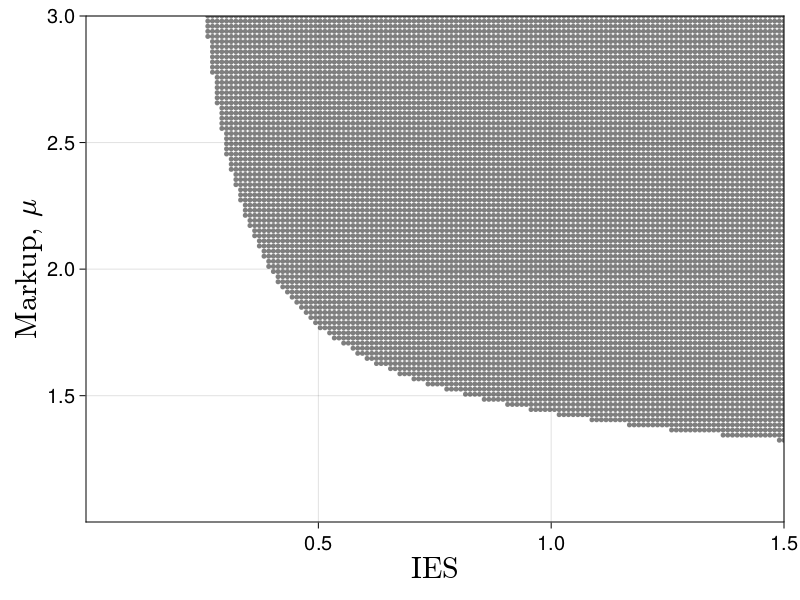

In [46]:
fig = make_RPI_plot(surface...; show_deviation_line = false)

In [47]:
save(joinpath(@__DIR__, "..", "output", "figures", "fig_neoclassical.pdf"), fig);